<a href="https://colab.research.google.com/github/trunghq0205/projects/blob/main/GraphRecSys/Graph_based_RecSys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Recommendation System - MTH10623 - Final Project**

**Tên đồ án: Graph-based Recommendation System - Hệ thống tư vấn dựa trên đồ thị**

Hệ thống gợi ý là một công nghệ quan trọng, tạo ra doanh thu trong nhiều dịch vụ hiện nay, cung cấp các gợi ý cho mạng xã hội, sản phẩm và các trong nhiều lĩnh vực khác trong cuộc sống.

Các phương pháp hệ thống gợi ý truyền thống sử dụng các độ đo tương đồng để đề xuất các sản phẩm khác thông qua các phương pháp lọc dựa trên nội dung và cộng tác. Tuy nhiên, dữ liệu sản phẩm có thể được biểu diễn dưới dạng đồ thị phi Euclid với các mối quan hệ như sản phẩm được mua cùng nhau hoặc xem cùng nhau. Các phương pháp hệ thống gợi ý truyền thống không xem xét các mối quan hệ đồ thị giữa các nút sản phẩm theo cách mà các mạng nơ-ron đồ thị làm. Một phương pháp dựa trên đồ thị để gợi ý sản phẩm có thể tận dụng hoàn toàn các mối quan hệ giữa các nút sản phẩm để tạo ra nhúng sản phẩm cải thiện có thể đại diện cho cấu trúc đồ thị của dữ liệu sản phẩm.

Trong đề tài này, chúng tôi sẽ sử dụng 2 kiến trúc GNN là Graph Convolutional Networks (GCN) và GraphSAGE để có thể sử dụng mối quan hệ đồ thị của dữ liệu sản phẩm và tạo ra các embedding chính xác và mạnh mẽ cho việc gợi ý sản phẩm.

## **Import các thư viện cần thiết**



DGL (Deep Graph Library) trong Python là thư viện mạnh mẽ cho việc xử lý đồ thị và học máy. Nó hỗ trợ đa dạng các loại đồ thị và cung cấp các mô hình học sâu như GCNs và GATs. DGL tối ưu hóa tính toán trên đồ thị lớn và tương thích với PyTorch, TensorFlow. Đây là công cụ tuyệt vời cho nghiên cứu và áp dụng trong xử lý dữ liệu đồ thị.

In [ ]:
# Cài đặt thư viện Deep Graph Learning
!pip install dgl

In [ ]:
import numpy as np
import pandas as pd
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import scipy.sparse as sp
import json
import gzip

In [ ]:
from dgl.nn import SAGEConv, GraphConv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
import dgl.data
import dgl.function as fn

In [ ]:
seed_value = 42
torch.manual_seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
dgl.seed(seed_value)

## **Giới thiệu bộ dataset**

Bộ dữ liệu Amazon product data của Julian McAuley từ UCSD là một trong những bộ dữ liệu lớn và phổ biến được sử dụng trong lĩnh vực học máy và khai phá dữ liệu.
Bộ dữ liệu này rất hữu ích để dùng trong nghiên cứu về các mô hình dự đoán đánh giá sản phẩm, phân loại sản phẩm và xây dựng các hệ thống gợi ý sản phẩm cho người dùng.

Với 142,8 triệu đánh giá kéo dài từ tháng 5 năm 1996 đến tháng 7 năm 2014 (Đối với phiên bản 2014), bộ dữ liệu này chứa các đánh giá sản phẩm (bao gồm điểm số rating, các đoạn văn bản, số lượt bình chọn hữu ích) và metadata (bao gồm mô tả, thông tin danh mục, giá cả, thương hiệu và đặc điểm hình ảnh của các sản phẩm) từ Amazon.

Toàn bộ bộ dữ liệu được chia thành các bộ dữ liệu con theo từng danh mục, ví dụ như Amazon-Books, Amazon-Instant Video và Amazon-Electronics. Các bộ dữ liệu con trong Amazon thường được sử dụng để kiểm tra hiệu suất trong việc lọc cộng tác người dùng-sản phẩm và đề xuất tuần tự.

Đường link lưu trữ bộ dữ liệu: https://jmcauley.ucsd.edu/data/amazon/links.html

Tập dữ liệu được sử dụng trong bài làm này chính là tập dữ liệu metadata `meta_Office_Products` (phiên bản năm 2014 của Amazon Product data), nằm trong danh mục văn phòng phẩm.

In [ ]:
# Download bộ dữ liệu
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Office_Products.json.gz

--2023-12-29 19:31:58--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/meta_Office_Products.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47605216 (45M) [application/x-gzip]
Saving to: ‘meta_Office_Products.json.gz.3’

meta_Office_Product 100%[===================>]  45.40M  9.18MB/s    in 6.9s    

2023-12-29 19:32:05 (6.54 MB/s) - ‘meta_Office_Products.json.gz.3’ saved [47605216/47605216]



## **Xử lý dữ liệu và xây dựng đồ thị**

In [ ]:
pd.options.mode.chained_assignment = None

Đây là tập dữ liệu trong định dạng JSON, dữ liệu mô tả thông tin về một sản phẩm trên Amazon bao gồm các thuộc tính:

`{'asin': '043950578X', \
'categories': [['Office Products', 'Office & School Supplies']], \
'description': 'Reproducible pages on the back of each chart!', \
'title': 'Scholastic Reading Is Succeeding Incentive Chart (TF2204)', \
'price': 2.49, \
'imUrl': 'http://ecx.images-amazon.com/images/I/61vJYM%2BMq2L._SY300_.jpg', \
'brand': 'Scholastic', \
'related': {'also_bought': ['B00207MG4Y', 'B00207MGDA'], 'also_viewed': ['B0007WXPWQ', 'B003VQH562']}}`

Trong đó:
- asin: Là một mã số định danh duy nhất cho từng sản phẩm
- title: Tên sản phẩm
- price: Giá sản phẩm theo đơn vị USD
- imUrl: Đường link hình ảnh của sản phẩm
- related: Các sản phẩm có liên quan, bao gồm: also bought, also viewed, bought together, buy after viewing.
- salesRank: Thông tin xếp hạng bán hàng
- brand: Nhãn hiệu sản phẩm
- categories: Danh sách chứa các danh mục của sản phẩm

Trước tiên, chúng tôi Tiến hành chuyển dữ liệu từ định dạng json sang dạng pandas DataFrame:

In [ ]:
# Giải nén tập tin
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

In [ ]:
# Chuyển file json sang dạng DataFrame
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [ ]:
df = getDF('./meta_Office_Products.json.gz')

In [ ]:
df.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand
0,0078800242,All in one TeacherWorks Plus CD-ROM,93.06,http://ecx.images-amazon.com/images/I/41K1aBkl...,{'buy_after_viewing': ['007861970X']},{'Software': 18529},"[[Office Products, Office & School Supplies, C...",NaN,NaN
1,0113000316,High quality inkjet cartridges use high-densit...,NaN,http://ecx.images-amazon.com/images/I/51AMwP3D...,NaN,NaN,"[[Office Products, Office & School Supplies, P...",123GetInk -14-pack 5-black 3-cyan 3-magenta 3-...,NaN
2,043928631X,"Harry Potter living bookmark showing Harry, He...",NaN,http://ecx.images-amazon.com/images/I/41SulB7T...,NaN,NaN,"[[Office Products, Office & School Supplies, L...",Harry Potter Lenticular Hologram Bookmark - Ha...,NaN
3,0439340039,Windows based computer game.,NaN,http://ecx.images-amazon.com/images/I/51zQE0w%...,NaN,{'Software': 32784},"[[Office Products, Office & School Supplies, E...",NaN,NaN
4,0439394058,"126 pieces: 23"" tall schoolhouse calendar, 12 ...",11.64,http://ecx.images-amazon.com/images/I/51DFp0Lg...,"{'also_bought': ['B000QE1HHU', 'B00207MG4Y', '...",NaN,"[[Office Products, Office & School Supplies, E...",Scholastic SC939405 All-In-One Schoolhouse Cal...,Scholastic


In [ ]:
data = df.copy()

### **Xử lý dữ liệu**

Trong bộ dữ liệu metadata, các sản phẩm được xác định bằng các số nhận dạng chuẩn duy nhất của Amazon, hay còn gọi là ASINs.

Chúng tôi loại bỏ tất cả các dòng dữ liệu bị thiếu (NaN), vì đây là tập dữ liệu chứa các đặc điểm của sản phẩm nên chúng tôi không thể sử dụng một phương pháp ước lượng nào để điền vào các điểm dữ liệu bị khuyết.

In [ ]:
data = data.dropna()

In [ ]:
data.shape

(9267, 9)

Sau đó, chúng tôi tiến hành lọc dữ liệu để giữ lại các dòng sản phẩm có chứa mục thông tin `also bought` trong cột `related`. Trong đó, `also bought` mô tả tất cả các ASINs của các sản phẩm được mua cùng với sản phẩm cụ thể đó. Những sản phẩm trong mục `also_bought` sẽ là các nút mục tiêu trong danh sách cạnh của chúng tôi.

In [ ]:
data.related = data.related.apply(lambda x: x if 'also_bought' in x.keys() else np.nan)
data = data.dropna()

In [ ]:
data.shape

(5237, 9)

Tạo cột `Also bought`, chứa thông tin tất cả các ASIN của sản phẩm đã được mua cùng với một sản phẩm cụ thể:

In [ ]:
data['also_bought'] = data.related.apply(lambda x: x['also_bought'])

In [ ]:
data.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand,also_bought
218,0641691858,"Punch Studio Cards, The Gifted Line, from the ...",19.97,http://ecx.images-amazon.com/images/I/51Fe8KMk...,"{'also_bought': ['0486288749', '0641678584', '...",{'Health & Personal Care': 205095},"[[Office Products, Office & School Supplies, P...","24 Greeting Card Assortment By Punch Studio, E...",Punch Studio,"[0486288749, 0641678584, 1595838376, 048626230..."
339,0954840526,An incredible map for children loaded with hun...,14.31,http://ecx.images-amazon.com/images/I/61nrOQlK...,"{'also_bought': ['B001GNFH12', '1905502109', '...",{'Toys & Games': 118577},"[[Office Products, Office & School Supplies, E...","World Prehistoric Illustrated, 38x54",Dino&#39;s Illustrated Maps,"[B001GNFH12, 1905502109, 1905502079, B001TJ7AB..."
343,0974632007,A full color shaded relief map showing portage...,21.41,http://ecx.images-amazon.com/images/I/41nMOlOS...,"{'also_bought': ['0935272437', '1929173733', '...",{'Sports &amp; Outdoors': 362780},"[[Office Products, Office & School Supplies, E...",Adirondack Paddler's Map,Paddlesports Press,"[0935272437, 1929173733, 0974632023, 159485061..."
602,1571335579,Pages: 240 (med/large)\nPage Color:Cream\nLayo...,8.50,http://ecx.images-amazon.com/images/I/31AfvxLQ...,"{'also_bought': ['1571335560', '1571338195', '...",{'Home &amp; Kitchen': 44686},"[[Office Products, Office & School Supplies, P...",Piccadilly Essential Large Notebook (Plain Pages),Piccadilly Inc,"[1571335560, 1571338195, 1571335544, 888370726..."
606,1574890239,Butterflies 18 assorted postcards per tin.,10.95,http://ecx.images-amazon.com/images/I/51VoH1Qm...,"{'also_bought': ['1574892304', '1574890220', '...",{'Home &amp; Kitchen': 332956},"[[Office Products, Office & School Supplies, P...","Cavallini Butterflies Carte Postale, 18 Postca...",Cavallini &amp; Co.,"[1574892304, 1574890220, 1574890905, 157489247..."


Tiếp theo, chúng tôi loại bỏ tất cả các sản phẩm `also_bought` không tồn tại trong tập dữ liệu.

In [ ]:
data['also_bought'] = data['also_bought'].apply(lambda x: set(data.asin).intersection(x))
data['also_bought'] = data['also_bought'].apply(lambda x: list(x) if len(x) > 0 else np.nan)

Nhưng trong quá trình loại bỏ các ASIN nằm bên ngoài tập dữ liệu, sẽ vô tình làm mất đi một số do ASIN sản phẩm nằm trong dữ liệu ban đầu do sử dụng phương thức drop NaN của pandas. Như minh họa ở hình bên dưới, sản phẩm C đã vô tình bị mất đi trong quá trình xử lý. Nhiêm vụ của chúng tôi là tái tạo lại thông tin của sản phẩm C, với also_bought là sản phẩm A.

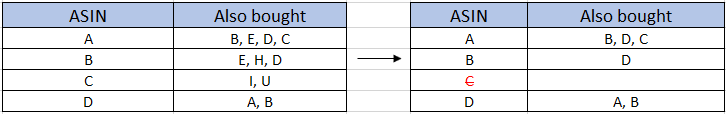

In [ ]:
data_copy = data.copy()
data = data.dropna().reset_index(drop=True)

In [ ]:
data.shape

(3806, 10)

Tiếp theo, thông qua cột danh mục - niche, chúng tôi thao tác để có được danh mục con hoặc chuyên mục cụ thể của sản phẩm nhằm mục đích có được label cho sản phẩm này:

In [ ]:
data['niche'] = data.categories.apply(lambda x: str(x).strip(']').split(',')[-1])

In [ ]:
data.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand,also_bought,niche
0,0641691858,"Punch Studio Cards, The Gifted Line, from the ...",19.97,http://ecx.images-amazon.com/images/I/51Fe8KMk...,"{'also_bought': ['0486288749', '0641678584', '...",{'Health & Personal Care': 205095},"[[Office Products, Office & School Supplies, P...","24 Greeting Card Assortment By Punch Studio, E...",Punch Studio,[1574891189],'Greeting Cards'
1,1571335579,Pages: 240 (med/large)\nPage Color:Cream\nLayo...,8.50,http://ecx.images-amazon.com/images/I/31AfvxLQ...,"{'also_bought': ['1571335560', '1571338195', '...",{'Home &amp; Kitchen': 44686},"[[Office Products, Office & School Supplies, P...",Piccadilly Essential Large Notebook (Plain Pages),Piccadilly Inc,"[B002RNRYN4, B000TKHALS]",'Hardcover Executive Notebooks'
2,1574890239,Butterflies 18 assorted postcards per tin.,10.95,http://ecx.images-amazon.com/images/I/51VoH1Qm...,"{'also_bought': ['1574892304', '1574890220', '...",{'Home &amp; Kitchen': 332956},"[[Office Products, Office & School Supplies, P...","Cavallini Butterflies Carte Postale, 18 Postca...",Cavallini &amp; Co.,"[1574892290, 1574892479, 1574890905, 1574892304]",'Postcards'
3,1574890131,New York 18 assorted postcards per tin.,12.57,http://ecx.images-amazon.com/images/I/51Kw6C7B...,"{'also_bought': ['1574898760', '1574898779', '...",{'Home &amp; Kitchen': 92513},"[[Office Products, Office & School Supplies, P...","Cavallini New York Carte Postale, 18 Postcards...",Cavallini &amp; Co.,"[1574898760, 1574897713, 1574898264, 157489230...",'Postcards'
4,1574890646,Vintage Paris Glitter Greetings,10.95,http://ecx.images-amazon.com/images/I/51hQGyfz...,"{'also_bought': ['1574898264', '1574891197', '...",{'Home &amp; Kitchen': 265981},"[[Office Products, Office & School Supplies, P...","Cavallini Vintage Paris Glitter Greetings, 12 ...",Cavallini &amp; Co.,"[1574898760, 1574892479, 1574898264, 157489242...",'Postcards'


In [ ]:
data = data.explode('also_bought')
data.head()

,asin,description,price,imUrl,related,salesRank,categories,title,brand,also_bought,niche
0,0641691858,"Punch Studio Cards, The Gifted Line, from the ...",19.97,http://ecx.images-amazon.com/images/I/51Fe8KMk...,"{'also_bought': ['0486288749', '0641678584', '...",{'Health & Personal Care': 205095},"[[Office Products, Office & School Supplies, P...","24 Greeting Card Assortment By Punch Studio, E...",Punch Studio,1574891189,'Greeting Cards'
1,1571335579,Pages: 240 (med/large)\nPage Color:Cream\nLayo...,8.50,http://ecx.images-amazon.com/images/I/31AfvxLQ...,"{'also_bought': ['1571335560', '1571338195', '...",{'Home &amp; Kitchen': 44686},"[[Office Products, Office & School Supplies, P...",Piccadilly Essential Large Notebook (Plain Pages),Piccadilly Inc,B002RNRYN4,'Hardcover Executive Notebooks'
1,1571335579,Pages: 240 (med/large)\nPage Color:Cream\nLayo...,8.50,http://ecx.images-amazon.com/images/I/31AfvxLQ...,"{'also_bought': ['1571335560', '1571338195', '...",{'Home &amp; Kitchen': 44686},"[[Office Products, Office & School Supplies, P...",Piccadilly Essential Large Notebook (Plain Pages),Piccadilly Inc,B000TKHALS,'Hardcover Executive Notebooks'
2,1574890239,Butterflies 18 assorted postcards per tin.,10.95,http://ecx.images-amazon.com/images/I/51VoH1Qm...,"{'also_bought': ['1574892304', '1574890220', '...",{'Home &amp; Kitchen': 332956},"[[Office Products, Office & School Supplies, P...","Cavallini Butterflies Carte Postale, 18 Postca...",Cavallini &amp; Co.,1574892290,'Postcards'
2,1574890239,Butterflies 18 assorted postcards per tin.,10.95,http://ecx.images-amazon.com/images/I/51VoH1Qm...,"{'also_bought': ['1574892304', '1574890220', '...",{'Home &amp; Kitchen': 332956},"[[Office Products, Office & School Supplies, P...","Cavallini Butterflies Carte Postale, 18 Postca...",Cavallini &amp; Co.,1574892479,'Postcards'


Cuối cùng, chúng tôi tạo lại những dòng sản phẩm đã vô tình bị mất đi trong quá trình xử lý như đã đề cập ở trước đó:

In [ ]:
# Tạo lại thông tin của các node bị mất trong quá trình xử lý dữ liệu

def refill_asin(orginal_data, stolen_asin_list, also_bought_stolen_asin_list):
  # Tạo một dataframe rỗng
  columns = ['asin', 'price', 'imUrl', 'description', 'categories', 'title', 'brand', 'related', 'salesRank', 'also_bought', 'niche']
  temp = pd.DataFrame(columns=columns)

  # Tạo lại thông tin của những asin đã bị mất
  col = ['asin', 'price', 'imUrl', 'description', 'categories', 'title', 'brand', 'related', 'salesRank']
  for i in range(len(stolen_asin_list)):
    new_row = orginal_data.loc[orginal_data['asin'] == stolen_asin_list[i], col]
    new_row['also_bought'] = also_bought_stolen_asin_list[i]
    new_row['niche'] = new_row.categories.apply(lambda x: str(x).strip(']').split(',')[-1])
    temp = pd.concat([temp, new_row], ignore_index=True)

  return temp

In [ ]:
stolen_asin = data.loc[~data['also_bought'].isin(data['asin'])]
list_stolen_asin = stolen_asin['also_bought'].tolist()
also_bought_stolen_asin = stolen_asin['asin'].tolist()

In [ ]:
temp_df = refill_asin(data_copy, list_stolen_asin, also_bought_stolen_asin)
# Nối hai DataFrame
data = pd.concat([data, temp_df])
# Reset index
data = data.reset_index(drop=True)

### **Xây dựng đồ thị (Graph)**

Trong ngữ cảnh của đề tài này, chúng tôi chỉ xây dựng một đồ thị đồng nhất (homogenous graph) bao gồm các sản phẩm dưới dạng các nút và các cạnh được kết nối với nhau với xem xét các nút đó có được mua cùng nhau hay không:
-	Node: Sản phẩm.
-	Edge: Cạnh nối các sản phẩm được mua cùng nhau.
-	Feature node: Tiêu đề (title), mô tả (description) của sản phẩm.


Đầu tiên chúng tôi lấy ra danh sách các cạnh trong đồ thị với node nguồn là sản phẩm ở trong cột asin và node đích là sản phẩm nằm trong cột also_bought:

In [ ]:
edges = data[['asin', 'also_bought']]

In [ ]:
edges

,asin,also_bought
0,0641691858,1574891189
1,1571335579,B002RNRYN4
2,1571335579,B000TKHALS
3,1574890239,1574892290
4,1574890239,1574892479
...,...,...
24993,B003GIS8TS,B00CI4IMOM
24994,B00DZ39M4E,B00DZ3CJRG
24995,B008N19SII,B00E4U48XM
24996,B007EEG7M0,B00E6MJGSA


Bởi vì ASINs/Product IDs của chúng tôi là kiểu chuỗi nên không thể nhập chúng vào mô hình, vì vậy tiếp theo chúng tôi sẽ ánh xạ tất cả các ASINs trong bộ dữ liệu thành một số nguyên duy nhất:

In [ ]:
asin_map_dict = pd.Series(pd.concat([edges.asin, edges.also_bought]).unique()).reset_index(drop=True).to_dict()
asin_map = {v: k for k, v in asin_map_dict.items()}

edges.asin = edges.asin.apply(lambda x: asin_map[x])
edges.also_bought = edges.also_bought.apply(lambda x: asin_map[x])
edges = edges.reset_index(drop=True)

In [ ]:
edges

,asin,also_bought
0,0,6
1,1,1707
2,1,760
3,2,13
4,2,16
...,...,...
24993,3860,3552
24994,3861,3632
24995,3862,3645
24996,3815,3651


Tạo đặc trưng cho node: Chúng tôi thực hiện việc biểu diễn các chuỗi văn bản từ 2 cột 'description' và 'title' thành các biểu diễn số hóa dựa trên TF-IDF, sau đó kết hợp các biểu diễn này thành một ma trận kết hợp để sử dụng cho việc huấn luyện mô hình.

Tạo node label: Tiếp theo chúng tôi thực hiện trích xuất node label là danh mục sản phẩm (niche categoty).

In [ ]:
# Text Manipulations
text_df = data[['asin', 'title', 'description', 'brand', 'niche']]
text_df.asin = text_df.asin.apply(lambda x: asin_map[x])
text_df = text_df.drop_duplicates('asin').reset_index(drop=True)
text_df.head()

,asin,title,description,brand,niche
0,0,"24 Greeting Card Assortment By Punch Studio, E...","Punch Studio Cards, The Gifted Line, from the ...",Punch Studio,'Greeting Cards'
1,1,Piccadilly Essential Large Notebook (Plain Pages),Pages: 240 (med/large)\nPage Color:Cream\nLayo...,Piccadilly Inc,'Hardcover Executive Notebooks'
2,2,"Cavallini Butterflies Carte Postale, 18 Postca...",Butterflies 18 assorted postcards per tin.,Cavallini &amp; Co.,'Postcards'
3,3,"Cavallini New York Carte Postale, 18 Postcards...",New York 18 assorted postcards per tin.,Cavallini &amp; Co.,'Postcards'
4,4,"Cavallini Vintage Paris Glitter Greetings, 12 ...",Vintage Paris Glitter Greetings,Cavallini &amp; Co.,'Postcards'


In [ ]:
from scipy.sparse import hstack
vectorizer_brand = TfidfVectorizer()
vectorizer_title = TfidfVectorizer()

X_des = vectorizer_brand.fit_transform(text_df['description'])
X_title = vectorizer_title.fit_transform(text_df['title'])

# Combine 'description', 'title' featuture
X = hstack((X_des, X_title))

In [ ]:
# Trích xuất node feature
node_features = torch.Tensor(X.toarray())

# Trích xuất node label
node_labels = torch.from_numpy(text_df['niche'].astype('category').cat.codes.to_numpy())


# Trích xuất danh sách cạnh
edges_src = torch.from_numpy(edges['asin'].to_numpy())
edges_dst = torch.from_numpy(edges['also_bought'].to_numpy())

In [ ]:
len(node_features)

3863

In [ ]:
len(edges_src)

24998

In [ ]:
def build_graph(node_features, node_labels, edges_src, edges_dst):
    '''
    Builds DGL Graph
    '''
    #Builds graph
    g = dgl.graph((edges_src, edges_dst))
    g.ndata['feat'] = node_features
    g.ndata['label'] = node_labels

    return g

Sau khi trích xuất node label, node feature và danh sách các cạnh trong đồ thị, chúng tôi bắt đầu xây dựng đồ thị một đồ thị đồng nhất gồm các sản phẩm làm nút và đưa đồ thị và các đặc trưng của đồ thị vào mô hình. Đồ thị của chúng tôi bao gồm 3863 và 24998 cạnh.

Chúng tôi chia các cạnh thành hai loại, positive edge và negative edge. Positive edge mô tả mối quan hệ thực sự giữa hai sản phẩm được mua cùng nhau, và các negative edge thì ngược lại, mô tả một mối quan hệ hoàn toàn không có.

### **Các thành phần quan trọng của quá trình huấn luyện mô hình**

**Chia đồ thị thành 2 phần huấn luyện (training) và thử nghiệm (testing):**

- Đầu tiên, chúng tôi tạo ra một đồ thị `train_g` bao gồm tất cả các nút và cạnh từ đồ thị gốc. Sau đó sẽ dựa vào các cạnh trong đồ thị để chia ra thành hai tập huấn luyện và tập thử nghiệm. Chúng tôi thực hiện phân chia theo tỉ lệ 90% các cạnh nằm trong tập thử nghiệm và 10% các cạnh nằm trong tập thử nghiệm.

- Trong các mô hình GNN, chúng ta thường tính toán biểu diễn cho từng nút trong đồ thị. Tuy nhiên, trong bài toán dự đoán liên kết, chúng ta cần tính toán biểu diễn cho các cặp nút, không chỉ riêng lẻ từng nút. Để giải quyết vấn đề này, thư viện mà chúng tôi sử dụng - DGL (Deep Graph Library), đề xuất xem các cặp nút như là một đồ thị mới. Bằng cách này, chúng ta có thể mô tả một cặp nút bằng một cạnh trong đồ thị mới này. Trong dự đoán liên kết, có hai đồ thị: một đồ thị tích cực (positive graph) chứa tất cả các ví dụ tích cực (những cặp nút có mối quan hệ liên kết), và một đồ thị tiêu cực (negative graph) chứa tất cả các ví dụ tiêu cực (những cặp nút không có mối quan hệ). Cả hai đồ thị này sẽ có cùng tập hợp các nút như đồ thị ban đầu, điều này giúp việc truyền các đặc trưng của nút giữa các đồ thị trở nên dễ dàng hơn. Sau này, chúng ta có thể trực tiếp sử dụng các node representations được tính toán trên toàn bộ đồ thị để tính toán điểm số cho các cặp nút trong cả positive graph và negative graph. Lợi ích khi xử lý các cặp nút như một đồ thị là chúng tôi có thể sử dụng phương thức `DGLGraph.apply_edges`, thuận tiện để tính toán các đặc trưng cạnh mới dựa trên các đặc trưng của các nút liên quan và các đặc trưng cạnh ban đầu (nếu có).

Chúng tôi đã xây dựng một hàm `train_test_split` để thực hiện tất cả các cong việc nêu trên.


In [ ]:
def train_test_split(g):
    '''
    Splits the graph by edges for training and testing

    Source: https://docs.dgl.ai/en/latest/new-tutorial/4_link_predict.html
    '''
    # Split edge set for training and testing
    u, v = g.edges()

    eids = np.arange(g.number_of_edges())
    eids = np.random.permutation(eids)
    test_size = int(len(eids) * 0.1)
    train_size = g.number_of_edges() - test_size
    test_pos_u, test_pos_v = u[eids[:test_size]], v[eids[:test_size]]
    train_pos_u, train_pos_v = u[eids[test_size:]], v[eids[test_size:]]

    # Find all negative edges and split them for training and testing
    adj = sp.coo_matrix((np.ones(len(u)), (u.numpy(), v.numpy())))
    adj_neg = 1 - adj.todense() - np.eye(g.number_of_nodes())
    neg_u, neg_v = np.where(adj_neg != 0)

    neg_eids = np.random.choice(len(neg_u), g.number_of_edges())
    test_neg_u, test_neg_v = neg_u[neg_eids[:test_size]], neg_v[neg_eids[:test_size]]
    train_neg_u, train_neg_v = neg_u[neg_eids[test_size:]], neg_v[neg_eids[test_size:]]

    train_g = dgl.remove_edges(g, eids[:test_size])

    train_pos_g = dgl.graph((train_pos_u, train_pos_v), num_nodes=g.number_of_nodes())
    train_neg_g = dgl.graph((train_neg_u, train_neg_v), num_nodes=g.number_of_nodes())

    test_pos_g = dgl.graph((test_pos_u, test_pos_v), num_nodes=g.number_of_nodes())
    test_neg_g = dgl.graph((test_neg_u, test_neg_v), num_nodes=g.number_of_nodes())


    return train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g

**Tính toán khả năng xuất hiện của một cạnh:**  Chúng tôi xây dựng một hàm để tính toán các đặc trưng cạnh mới cho đồ thị g dựa trên thông tin biểu diễn của các nút. Cụ thể, nó thực hiện việc tính tích vô hướng của các biểu diễn của các nút liên quan để tạo ra các đặc trưng cạnh mới cho từng cạnh trong đồ thị. Dựa vào kết quả của tích vô hướng này, chúng tôi có được một xác suất tồn tại của một cạnh và dùng nó trong quá trình huấn luyện mô hình sau này.

In [ ]:
class DotPredictor(nn.Module):
    '''
    Dot Predictor of Edges,

    Source:
    https://docs.dgl.ai/en/latest/new-tutorial/4_link_predict.html
    '''
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            # Compute a new edge feature named 'score' by a dot-product between the
            # source node feature 'h' and destination node feature 'h'.
            g.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            # u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata['score'][:, 0]


**Hàm loss và các chỉ số đánh giá mô hình**

Hàm loss mà chúng tôi sử dụng là binary cross entropy loss:

$\mathcal{L}=- \displaystyle\sum_{u∼v∈D} (y_{u∼v}log(\hat{y}_{u∼v})+(1−y_{u∼v})log(1−\hat{y}_{u∼v})))$

In [ ]:
# Tính toán giá trị hàm Loss
def compute_loss(pos_score, neg_score):
    '''
    Computes cross entropy loss on edge features
    Source: https://docs.dgl.ai/en/latest/new-tutorial/4_link_predict.html
    '''
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])])
    return F.binary_cross_entropy_with_logits(scores, labels)

Chỉ số đánh giá mô hình mà chúng tôi sử dụng là AUC:

In [ ]:
def compute_auc(pos_score, neg_score):
    scores = torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat(
        [torch.ones(pos_score.shape[0]), torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

Đồng thời, để đánh giá các đề xuất sản phẩm từ mô hình, chúng tôi đã sử dụng một độ đo được gọi là tỉ lệ trúng đích (hit rate) cho top-K sản phẩm được đề xuất với K = 20. Với một sản phẩm chưa được nhìn thấy, mô hình sẽ tạo ra các nút sản phẩm được embedding gần nhất trong top-K để đưa ra đề xuất. Nếu ít nhất một trong số các sản phẩm được đề xuất có kết nối với sản phẩm chưa được nhìn thấy này, chúng tôi sẽ coi đó là một trường hợp trúng đích. Chúng tôi tính toán tỉ lệ trúng đích (hit rate) tại K bằng cách lấy số lượng trường hợp trúng đích chia cho số lượng sản phẩm kiểm thử chưa được xem xét.

In [ ]:
# Tính toán chỉ số hit rate
def get_hits(edges_df, h, h_test):
    '''
    Gets list of hits given the parameters below

    parameters: edges list df,
                h embedings from training,
                h_test embeddings from test set.
    returns: list of hits
    '''
    hits = []
    edges = edges_df
    for i in range(h.shape[0]):
        true_edges = list(edges[edges.asin == i].also_bought)
        dist = torch.cdist(h_test[[i]], h)
        top_k = torch.topk(dist, k = 20, largest=False)[1]
        hit = 0
        for j in true_edges:
            if j in top_k:
                hit = 1
                break
        hits.append(hit)
    return hits

### **Định nghĩa và huấn luyện mô hình GCN và GraphSAGE**

#### **Định nghĩa mô hình**

**Định nghĩa mô hình GCN:**

In [ ]:
class GCN(nn.Module):
    '''
    DGL 2-Layer GCN Model
    '''
    def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.gcn1 = GraphConv(in_feats, h_feats)
        self.gcn2 = GraphConv(h_feats, h_feats)

    def forward(self, g, in_feat):
        # Apply the first GCN layer
        h = self.gcn1(g, in_feat)
        h = F.relu(h)
        # Apply the second GCN layer
        h = self.gcn2(g, h)
        return h

**Định nghĩa mô hình GraphSAGE:**

Mô hình GraphSAGE của chúng tôi hoạt động chỉ dựa trên đặc trưng của nút (tiêu đề và mô tả sản phẩm) và các mối quan hệ thông qua các cạnh của các sản phẩm được mua cùng nhau. Mô hình bao gồm hai lớp, mỗi lớp tổng hợp các nút hàng xóm dựa bằng cách sử dụng hàm tổng hợp giá trị trung bình.

In [ ]:
class GraphSAGE(nn.Module):
    '''
    DGL 2-Layer GraphSAGE Model
    Source: https://docs.dgl.ai/en/0.4.x/_modules/dgl/nn/pytorch/conv/sageconv.html
    '''
    def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, 'mean')
        self.conv2 = SAGEConv(h_feats, h_feats, 'mean')

    def forward(self, g, in_feat):
        # Apply the first GraphSAGE layer
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        # Apply the second GraphSAGE layer
        h = self.conv2(g, h)
        return h

#### **Training mô hình**

**Quá trình training mô hình**

Tại mỗi bước của mô hình, chúng tôi sẽ cho mô hình học thông qua việc tính tích vô hướng của cả nút nguồn và nút đích sau đó áp dụng đặc trưng đó vào một cạnh. Bởi vì chúng tôi có cả các cạnh tích cực và tiêu cực mô tả mối quan hệ mua hàng thật và giả giữa các sản phẩm, vì vậy chúng tôi sẽ so sánh cả hai loại cạnh này với kết quả dư đoán từ mô hình của chúng tôi thông qua hàm DotPrediction. Cuối cùng, chúng tôi tính tổng lỗi thông qua hàm mất mát entropy nhị phân.

In [ ]:
g = build_graph(node_features, node_labels, edges_src, edges_dst)

# Train-Test Split Graphs
train_g, train_pos_g, train_neg_g, test_pos_g, test_neg_g = train_test_split(g)

train_g = dgl.add_self_loop(train_g)
test_pos_g = dgl.add_self_loop(test_pos_g)

**Training mô hình GCN**

In [ ]:
# Inits
GCN_model = GCN(train_g.ndata['feat'].shape[1], 32)
pred = DotPredictor()
optimizer = torch.optim.Adam(itertools.chain(GCN_model.parameters(), pred.parameters()), lr = 0.002)
epochs = 100

# Training
for epoch in range(epochs):
  # Forward
  h = GCN_model(train_g, train_g.ndata['feat'])
  pos_score = pred(train_pos_g, h)
  neg_score = pred(train_neg_g, h)
  train_loss = compute_loss(pos_score, neg_score)

  # Backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  print('In epoch {}, train loss = {}'.format(epoch, train_loss))

In epoch 0, train loss = 0.6930807828903198
In epoch 1, train loss = 0.6909005641937256
In epoch 2, train loss = 0.6851670145988464
In epoch 3, train loss = 0.6747316122055054
In epoch 4, train loss = 0.6600213646888733
In epoch 5, train loss = 0.6427887678146362
In epoch 6, train loss = 0.6257479786872864
In epoch 7, train loss = 0.6114543676376343
In epoch 8, train loss = 0.6004858016967773
In epoch 9, train loss = 0.5911138653755188
In epoch 10, train loss = 0.5815028548240662
In epoch 11, train loss = 0.5712748169898987
In epoch 12, train loss = 0.5610460042953491
In epoch 13, train loss = 0.5515619516372681
In epoch 14, train loss = 0.5431957840919495
In epoch 15, train loss = 0.5358989238739014
In epoch 16, train loss = 0.5294121503829956
In epoch 17, train loss = 0.5234894156455994
In epoch 18, train loss = 0.5180114507675171
In epoch 19, train loss = 0.5129592418670654
In epoch 20, train loss = 0.5083739161491394
In epoch 21, train loss = 0.5043016076087952
In epoch 22, train l

In [ ]:
with torch.no_grad():
  test_pos_score = pred(test_pos_g, h)
  test_neg_score = pred(test_neg_g, h)
  test_loss = compute_loss(test_pos_score, test_neg_score)
  test_auc = compute_auc(test_pos_score, test_neg_score)

  print(f'test loss = {test_loss}')
  print(f'AUC = {test_auc}')

test loss = 0.333258718252182
AUC = 0.9339262897865843


In [ ]:
hits = get_hits(edges, h, GCN_model(test_pos_g, node_features))
print(np.mean(hits))
print(hits)

0.6922081283976185
[0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,

**Training mô hình GraphSAGE**

In [ ]:
# Inits
graphSAGE_model = GraphSAGE(train_g.ndata['feat'].shape[1], 32)
pred = DotPredictor()

optimizer = torch.optim.Adam(itertools.chain(graphSAGE_model.parameters(), pred.parameters()), lr=0.002, weight_decay=0.0025)
epochs = 100

# Training
for epoch in range(epochs):
  # Forward
  h = graphSAGE_model(train_g, train_g.ndata['feat'])
  pos_score = pred(train_pos_g, h)
  neg_score = pred(train_neg_g, h)
  train_loss = compute_loss(pos_score, neg_score)


  # Backward
  optimizer.zero_grad()
  train_loss.backward()
  optimizer.step()

  print('In epoch {}, train loss = {}'.format(epoch, train_loss))

In epoch 0, train loss = 0.714363694190979
In epoch 1, train loss = 0.6978174448013306
In epoch 2, train loss = 0.6850616931915283
In epoch 3, train loss = 0.6705697774887085
In epoch 4, train loss = 0.6517038941383362
In epoch 5, train loss = 0.6282858848571777
In epoch 6, train loss = 0.601927638053894
In epoch 7, train loss = 0.5758299231529236
In epoch 8, train loss = 0.5535326600074768
In epoch 9, train loss = 0.5371425151824951
In epoch 10, train loss = 0.5257858037948608
In epoch 11, train loss = 0.5165233612060547
In epoch 12, train loss = 0.5072118043899536
In epoch 13, train loss = 0.4975356161594391
In epoch 14, train loss = 0.4883101284503937
In epoch 15, train loss = 0.48036155104637146
In epoch 16, train loss = 0.4739534854888916
In epoch 17, train loss = 0.4687562584877014
In epoch 18, train loss = 0.4641416668891907
In epoch 19, train loss = 0.45966774225234985
In epoch 20, train loss = 0.4550887942314148
In epoch 21, train loss = 0.45036107301712036
In epoch 22, train 

In [ ]:
with torch.no_grad():
  test_pos_score = pred(test_pos_g, h)
  test_neg_score = pred(test_neg_g, h)
  test_loss = compute_loss(test_pos_score, test_neg_score)
  test_auc = compute_auc(test_pos_score, test_neg_score)

  print(f'test loss = {test_loss}')
  print(f'AUC = {test_auc}')

test loss = 0.315297394990921
AUC = 0.9504013488451024


In [ ]:
hits = get_hits(edges, h, graphSAGE_model(test_pos_g, node_features))
print(np.mean(hits))
print(hits)

0.7411338338079213
[0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,

### **Nhận xét và tổng kết**

Khi xét trên tiêu chí AUC thì kết quả của hai mô hình GCN và GraphSAGE đều khá tốt, với AUC trên tập test đều trên 90%. Tuy nhiên, nhìn chung thì GraphSAGE có kết quả tốt hơn so với GCN ở phần lớn các tiêu chí khác đó là test loss, AUC và hit rate. Cụ thể, AUC của GraphSAGE là 0.9504, cao hơn AUC của GCN là 0.9339. Tỷ lệ trúng đích hit rate của GraphSAGE là 0.7411, cao hơn hit rate của GCN là 0.6922. Giá trị hàm mất mát của GraphSAGE cũng bé hơn GCN kiểm tra mặc dù trên tập huấn luyện thì GCN là mô hình có giá trị lối thấp hơn. Thời gian training của mô hình GCN cũng nhanh hơn mô hình GraphSAGE, 75.138 giây so với 83.918 giây, tuy nhiên đây là lượng thời gian không đnags kể (cả 2 đều được huấn luyện qua 100 epochs).

Như vậy, thông qua bảng tổng kết trên thì ta có thể nhận xét rằng GraphSAGE là mô hình có hiệu quả tốt hơn GCN trong bài toán này, đặc biệt là dựa trên chỉ số hit rate cho thấy sự đề xuất hiệu quả hơn của GraphSAGE. Mặc dù đây không phải là kết quả tối ưu nhất, nhưng kết quả của chúng tôi đã cho thấy rằng việc đề xuất sản phẩm có thể được thực hiện được bằng cách sử dụng mạng neural đồ thị.

Chúng tôi đã chỉ ra cách mạng nơ-ron tích chập đồ thị có thể được sử dụng trong ngữ cảnh hệ thống đề xuất, trong đó có thể sử dụng dữ liệu dạng đồ thị để tận dụng được mối quan hệ của các đối tượng bên cạnh các đặc trưng được xem xét bởi các phương pháp truyền thống. Bằng cách sử dụng bộ dữ liệu văn phòng phẩm từ Amazon, chúng tôi đã xây dựng một đồ thị sản phẩm đồng nhất với các cạnh giữa các sản phẩm mua cùng nhau và áp dụng 2 mạng nơ-ron đồ thị khác nhau là GCN và biến thể nhỏ của nó GraphSAGE để đề xuất sản phẩm. Mô hình GraphSAGE đã vượt trội hơn một chút so với mô hình GCN, nhưng cả hai mô hình này đều có thể được cải thiện, vì chúng tôi chưa đạt được kết quả mà chúng tôi mong đợi.


Đối với dự án này, những hướng tối ưu trong tương lai có thể được chúng tôi xem xét là thu thập thêm các đặc trưng của người dùng hoặc sử dụng thêm các đặc trưng sản phẩm như giá cả, nhãn hiệu, danh mục sản phẩm. Ngoài ra, bên cạnh tập dữ liệu metadata mà chúng tôi sử dụng trong dự án này, thì kho dữ liệu sản phẩm của Amazon còn cung cấp các tập dữ về đánh giá của người dùng như văn bản đánh giá, điểm đánh giá của người dùng (rating) và đặc trưng hình ảnh của sản phẩm. Chúng tôi có thể sử dụng thêm những đặc trưng nói trên để cải thiện hiệu suất của mô hình. Một xem xét khác là xây dựng một đồ thị bao gồm nhiều quan hệ hơn thay vì chỉ bao gồm một quan hệ sản phẩm được mua cùng nhau như chúng tôi đã làm, các quan hệ này có thể là sản phẩm được xem cùng nhau (also view), được mua sau khi xem (buy after viewing), hoặc một đồ thị hợp nhất sẽ sử dụng cả các cạnh item-item và cạnh user-item và sử dụng một thuật toán hiện đại và tiên tiến hơn.

